# A Diffusion Model from Scratch in Pytorch

Very simple diffusion model for infectious disease dynamics

## Investigating the dataset

Let's inspect the Thailand Dengue dataset: https://www.tycho.pitt.edu/dataset/TH.38362002/

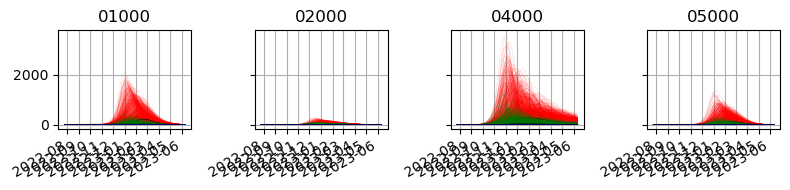

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr


    
    
def show_curves(datset, grid=(1,4)):
    fig, axes = plt.subplots(grid[0], grid[1], sharex=True, sharey=True, figsize=(grid[1]*2,grid[0]*2))
    for i, ax in enumerate(axes.flat):
        c = ['red', 'green', 'blue']
        place = datset.get_index('place')[i]
        tp = datset.sel(place=place)
        for k, val in enumerate(datset.feature):
            ax.plot(tp.date, tp.sel(feature=val).T, c = c[k], lw = .1, alpha=.5)
            ax.plot(tp.date, tp.sel(feature=val).T.median(axis=1), 
                    c = 'k',#'dark'+c[k], 
                    lw = .5, 
                    alpha=1)
        ax.grid()
        ax.set_title(place)
    fig.autofmt_xdate()
    fig.tight_layout()
    
class FluDynamicsDataset(torch.utils.data.Dataset):
    def __init__(self, netcdf_file, transform=None):
        """
        Args:
            netcdf_file (string): Path to the netcdf file with the xarray data
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.flu_dyn = xr.open_dataarray(netcdf_file)
        self.transform = transform
        
        # let's store the min and max
        self.max_per_feature = self.flu_dyn.max(dim=["date", "place", "sample"])
        print(f"created dataset with scale {np.array(self.max_per_feature)}")
        self.flu_dyn_norm = (np.sqrt(self.flu_dyn)/np.sqrt(self.max_per_feature))*3
        
        
    def __len__(self):
        return len(self.flu_dyn.sample)
    
    def __getitem__(self, idx):
        frame, idx = self.getitem_nocast(idx)
        return torch.from_numpy(frame).float(), idx
    
    def getitem_nocast(self, idx):
        if torch.is_tensor(idx):
            idxl = idx.tolist()
        else:
            idxl=idx
            
        epi_frame = self.flu_dyn_norm.sel(sample=idxl).squeeze().to_numpy()#.astype(np.float32)

        #shoudle be a dict ?
        #sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            epi_frame = self.transform(epi_frame)

        return epi_frame, idx
    
    def unnormalized(self, array):
        return (((array)/3)*np.sqrt((self.max_per_feature.to_numpy())[:,np.newaxis, np.newaxis]))**2
        #return (((array+1)/2)*np.sqrt((self.max_per_feature.to_numpy())[:,np.newaxis, np.newaxis]))**2
        #return ((array+.75)*np.sqrt((self.max_per_feature.to_numpy())[:,np.newaxis, np.newaxis]))**2
    
    def test(self, idx):
        """
        test that we can transform and go back & get the same thing
        """
        epi_frame_n, idx_n = self.getitem_nocast(idx)
        assert idx_n == idx
        #print(self.unnormalized(epi_frame_n).shape, self.unnormalized(epi_frame_n)[0,0,0])
        #print(self.flu_dyn.sel(sample=idx).shape, self.flu_dyn.sel(sample=idx)[0,0,0])
        assert (np.abs(self.unnormalized(epi_frame_n) - self.flu_dyn.sel(sample=idx)) < 1e-3).all()
    

flu_dyn = xr.open_dataarray('datasets/from_csp_weekly_pad_4scn.nc')#.to_array(name='from_csp') #torchvision.datasets.StanfordCars(root=".", download=True)
show_curves(flu_dyn)
dates= list(flu_dyn.date.values)
places=list(flu_dyn.place.values)
features=list(flu_dyn.feature.values)

In [2]:
data = FluDynamicsDataset('datasets/from_csp_weekly_pad_4scn.nc')
data.test(7)
data.test(19)

created dataset with scale [13575.0726171   5368.98319629    17.73463991]


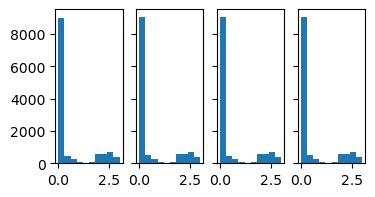

In [3]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(4,2))
for i in range(4):
    ax = axes.flat[i]
    ax.hist(data.__getitem__(i)[0].flatten())

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect. 

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [4]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [5]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

#IMG_SIZE = 64
BATCH_SIZE = 512

def load_transformed_dataset():
    data_transforms = [
        #transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        #torch.from_numpy(),
        #transforms.ToTensor(), # Scales data into [0,1] 
        #transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)
    
    data = FluDynamicsDataset('datasets/from_csp_weekly_pad_4scn.nc', transform=data_transform)
    
    return data

data = load_transformed_dataset()


dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True) # Dataset is shuffled, but the last incompleted batch is dropped

created dataset with scale [13575.0726171   5368.98319629    17.73463991]


In [6]:
dataloader

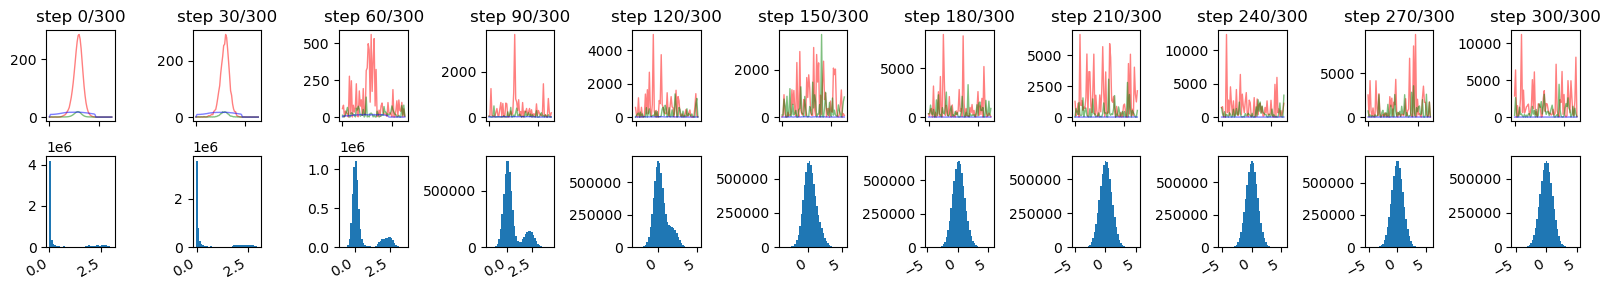

In [7]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

def plot_to_ax(array, ax=None, place=0):
    c = ['red', 'green', 'blue']
    # (3, 48, 51)
    if len(array.shape) == 4: # it's a batch
        array = array[0, :, :, :] 
    if ax is None:
        ax = plt.gca() # get current ax
    for k in range(3):
        ax.plot( array[k, :, place], c = c[k], lw = 1, alpha=.5) # dates,print(arr
def show_tensor_image(image, ax=None, place=0):
    plot_to_ax(data.unnormalized(image.numpy()), ax=ax, place=place)

num_images = 10
fig, axes = plt.subplots(2, num_images+1, figsize=(16,3), dpi=100)

stepsize = int(T/num_images)

i = 0
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    show_tensor_image(image, ax = axes[0][i])
    axes[0][i].set_title(f"step {idx}/{T}")
    axes[1][i].hist(image.numpy().flatten(), bins=40)
    image, noise = forward_diffusion_sample(image, t)
    
    i+=1
idx+=stepsize
axes[0][i].set_title(f"step {idx}/{T}")
show_tensor_image(image, ax = axes.flat[i])
axes[1][i].hist(image.numpy().flatten(), bins=40)
fig.autofmt_xdate()
fig.tight_layout()
    

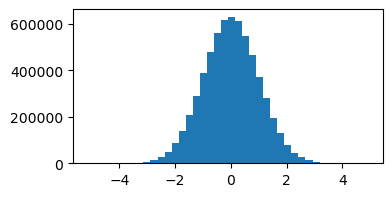

In [8]:
# let's check that's it's really noise after:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4,2))
for i in range(1):
    #ax = axes.flat[i]
    ax.hist(image.numpy().flatten(), bins=40)


## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [9]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [10]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    #return F.l1_loss(noise, noise_pred)
    return F.mse_loss(noise, noise_pred, reduction='sum')

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [11]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img = torch.randn((1, 3, 64, 64), device=device)
    
    num_images = 10
    fig, axes = plt.subplots(3, num_images+0, figsize=(16,4), dpi=100)
    k=0
    stepsize = int(T/num_images)
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            show_tensor_image(img.detach().cpu()[0,:,:,:], ax = axes[0][k])
            axes[1][k].hist(img.detach().cpu()[0,:,:,:].flatten(), bins=40)
            axes[1][k].set_xlim(-3,3)
            show_tensor_image(torch.swapaxes(img.detach().cpu()[0,:,:,:],1,2), ax = axes[2][k])
            axes[0][k].set_title(f"step {i}/{T}")
            k+=1
    # This just replot the last image. What is not plottted is the noise at the beggining.
    #show_tensor_image(img.detach().cpu()[0,:,:,:], ax = axes[0][-1])
    #axes[1][-1].hist(img.detach().cpu()[0,:,:,:].flatten(), bins=40)
    #axes[1][-1].set_xlim(-3,3)
    #show_tensor_image(torch.swapaxes(img.detach().cpu()[0,:,:,:],1,2), ax = axes[2][-1])
    #axes[0][-1].set_title(f"step {i}/{T}")
            
    fig.autofmt_xdate()
    fig.tight_layout()       

In [12]:
for i in range(0,T)[::-1]:
    if i % stepsize == 0: print(i)

270
240
210
180
150
120
90
60
30
0


## Training

using  cuda
Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
16.194207744  /  16.945512448
Epoch 0 | step 000 Loss: 6555235.5
CUDA memory: using 3.30/16.95 Gb


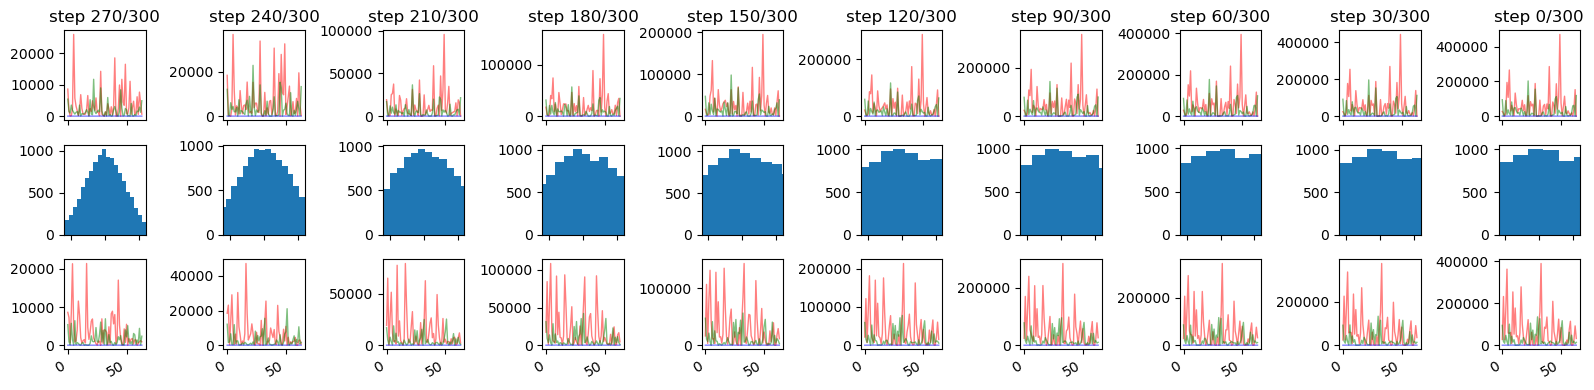

Epoch 100 | step 000 Loss: 284975.125
CUDA memory: using 0.06/16.95 Gb


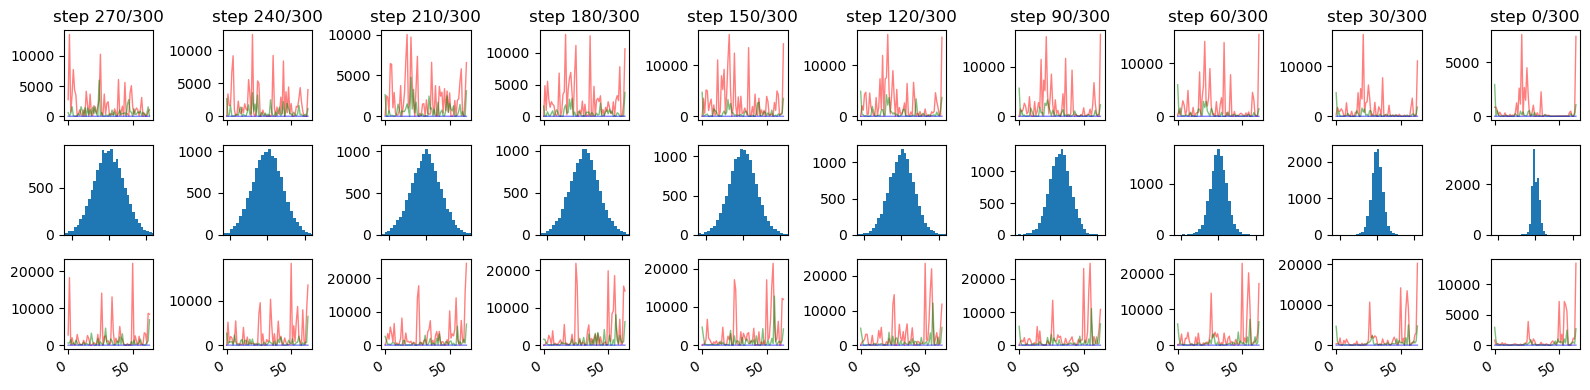

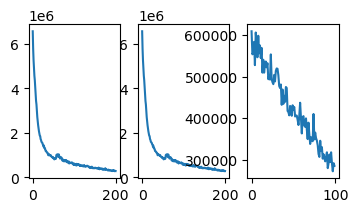

Epoch 200 | step 000 Loss: 155170.34375
CUDA memory: using 0.06/16.95 Gb


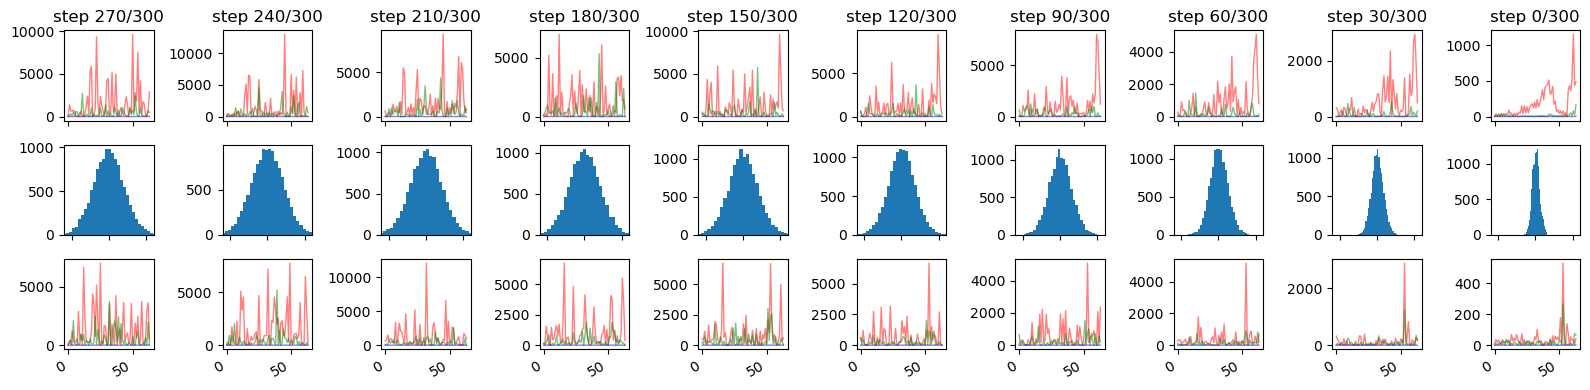

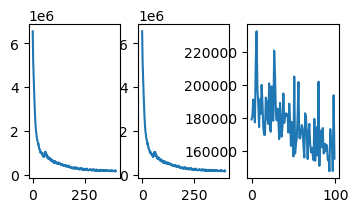

Epoch 300 | step 000 Loss: 132130.625
CUDA memory: using 0.06/16.95 Gb


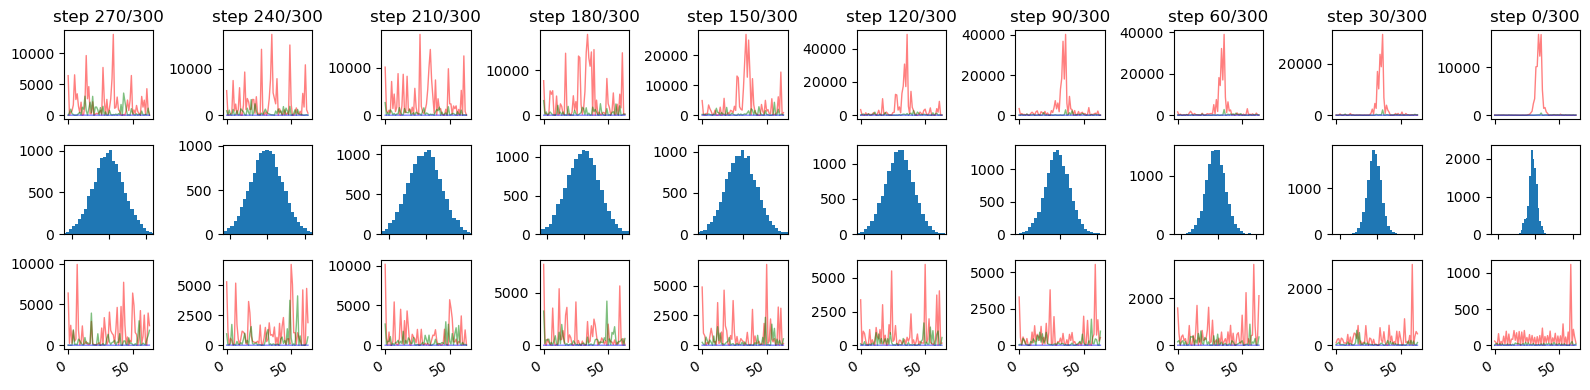

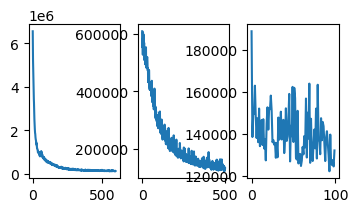

Epoch 400 | step 000 Loss: 187220.21875
CUDA memory: using 0.06/16.95 Gb


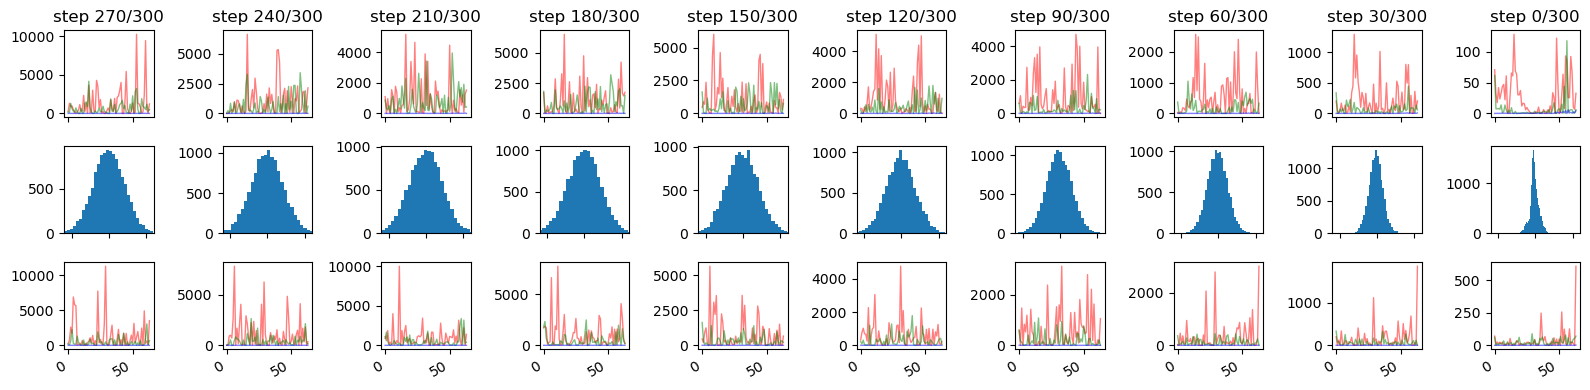

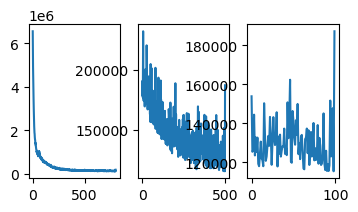

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using ", device)
#Additional Info when using cuda
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print(torch.cuda.mem_get_info()[0]/1e9, ' / ', torch.cuda.mem_get_info()[1]/1e9)

model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 30000 # Try more!
losses = []

scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      #batch[0]  = batch[0].type(torch.cuda.FloatTensor)
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if epoch % 100 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()}")
        print(f"CUDA memory: using {torch.cuda.mem_get_info()[0]/1e9:.2f}/{torch.cuda.mem_get_info()[1]/1e9:.2f} Gb")
        sample_plot_image()
        plt.show()
        if epoch>0:
            fig, axes = plt.subplots(1, 3, figsize=(4,2), dpi=100)
            axes.flat[0].plot(np.arange(len(losses)), np.array(losses))
            axes.flat[1].plot(np.arange(len(losses[-500:])), np.array(losses[-500:]))
            axes.flat[2].plot(np.arange(len(losses[-100:])), np.array(losses[-100:]))
            plt.show()
    scheduler1.step()

In [ ]:
print(epoch)
print(step, len(batch))
print(batch[0].type(), batch[0].shape)
print(batch[1].type(), batch[1].shape)
print(t.type(), t.shape)

In Table 2, we show the sample quality effects of reverse process parameterizations and training
objectives (Section 3.2). We find that the baseline option of predicting µ˜ works well only when
trained on the true variational bound instead of unweighted mean squared error, a simplified objective
akin to Eq. (14). We also see that learning reverse process variances (by incorporating a parameterized
diagonal Σθ(xt) into the variational bound) leads to unstable training and poorer sample quality
compared to fixed variances. Predicting , as we proposed, performs approximately as well as
predicting µ˜ when trained on the variational bound with fixed variances, but much better when trained
with our simplified objective.


iffusion models scale down the data with each forward process step (by a √
1 − βt factor)
so that variance does not grow when adding noise, thus providing consistently scaled inputs
to the neural net reverse process. NCSN omits this scaling factor.
